# Heatmap compsoed model
 - heatmap-edge2.pth


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
import pickle

class HeatmapDataset(Dataset):
    """My dataset."""

    def __init__(self, pickle_path, transform=None, n_sample=None):
        super(HeatmapDataset, self).__init__()
        self.pickle_path = pickle_path
        self.transform = transform
        self.upsample = nn.UpsamplingBilinear2d([224,224])
        
        # load
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
            self.boxes_data = torch.tensor(data['boxes']) # np array
            self.heatmap_data = data['heatmaps'] # cls,ch,h,w tensor
            self.targets = torch.tensor(data['targets']) # np array
            self.sobels = data['sobels'] # 1,224,224 tensor
            
        # n개만 샘플링 - validation용
        if(n_sample is not None):
            sample_indices = np.random.choice(len(self.heatmap_data), n_sample, replace=False)
            self.boxes_data = self.boxes_data[sample_indices]
            self.heatmap_data = self.heatmap_data[sample_indices]
            self.targets = self.targets[sample_indices]
            self.sobels = self.sobels[sample_indices] 

        self.n_classes = self.targets.max().item() + 1
        assert len(self.heatmap_data)==len(self.boxes_data), "num_heatmap != num_box"

    def __len__(self):
        return len(self.heatmap_data)

    def __getitem__(self, idx):
        bboxes = self.boxes_data[idx]
        targets = self.targets[idx]
        sobels = torch.stack([self.sobels[idx]]*self.n_classes) # cls, 1, 224, 224
        sobels = sobels.transpose(0,1) # 1, cls, 224, 224
        
        heatmap = self.heatmap_data[idx]
        heatmap = self.upsample(heatmap) # cls, ch, 224, 224 - 4d tensor
        heatmap = heatmap.transpose(0,1) # ch, cls, 224, 224 - 4d tensor
        heatmap = torch.cat([heatmap, sobels]).transpose(0,1) # cls, ch+1, 224, 224 - 4d tensor
        
        if self.transform:
            heatmap = self.transform(heatmap).unsqueeze(0)

        one_hot = torch.zeros(self.n_classes)
        one_hot[targets.squeeze().long()] = 1
        #  현재 프레임당 bbox 1개씩 뿐이라 sqaueeze힌것. 여러개땐 차원 고려해야함
        return heatmap.float(), bboxes.squeeze().float(), one_hot

# def myCollate(batch):
#     img_list = []
#     box_list = []
#     for img, box in batch:
#         img_list.append(img)
#         box_list.append(box)
#     return torch.stack(img_list), torch.stack(box_list)

In [3]:
pickle_path = 'heatmap_voc_1127.pickle'
pickle_val_path = 'heatmap_21_1127_val.pickle'

my_dataset = HeatmapDataset(pickle_path)
my_dataset_val = HeatmapDataset(pickle_val_path)#, n_sample=100)


my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=4, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)
my_loader_val = torch.utils.data.DataLoader(my_dataset_val, batch_size=4, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)


dataloaders = {
    'train': my_loader,
    'val': my_loader_val
}
dataset_sizes = {
    'train': len(my_dataset),
    'val': len(my_dataset_val)
}
# i,b = next(iter(my_loader))
# i.shape, b.shape

print(dataset_sizes)

{'train': 4756, 'val': 135}


In [4]:
set(my_dataset_val.targets.squeeze().numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [5]:
my_dataset[0][0].shape, my_dataset[0][1].shape, my_dataset[0][2].shape

(torch.Size([20, 4, 224, 224]), torch.Size([4]), torch.Size([20]))

In [6]:
# my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=8, #collate_fn=myCollate,
#                                           shuffle=True, num_workers=0)

# loader = iter(my_loader_test)

def cvt_yolobox_tensor(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,x2,y2
    """
    bboxes = bboxes_yolo.clone() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1] + bboxes[:,0]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0] + bboxes[:,1]
    return bboxes

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

def IOU_loss(ious):
    """
    @params ious - N length tensor
    """
    loss = -1 * (ious +1e-9).log() 
    return loss.sum()

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
        
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(4, 32, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.backbone2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(4, 32, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)

                
        # fc layer
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 5), # score_logit + cx,cy,w,h
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - b,cls,ch,224,224
        """
        n_batch = inputs.shape[0] # b
        n_channel = inputs.shape[2] # ch
        # CNN backbone
        images = inputs.transpose(0,1).reshape(-1,n_channel,224,224) # b*cls,ch,224,224
        hh = self.backbone(images) # b*cls,256 
        hh2 = self.backbone2(images) # b*cls,256 
        hh3 = torch.cat([hh,hh2], dim=1) #b*cls,512
        hh3 = hh3.reshape(-1, n_batch, 512) # cls,b,256
        
        attn_output, attn_output_weights = self.multihead_attn(hh3, hh3, hh3) # q,k,v - L,N,E - cls,b,256        
        attn_sum = hh3+attn_output # cls,b,256
        
        res = attn_sum.transpose(0,1) # b,cls,256

        res2 = res.reshape(-1,512) # b*cls,256
        
        pp = self.fc(res2) # b*cls,5(1+4)
        pp = pp.reshape(n_batch,-1,5) # b,cls,5(1+4)
        logit = pp[:,:,0] # b,cls
        coords = pp[:,:,1:] # b,cls,4
        
        return logit, coords

In [16]:
from torchsummary import summary
model = BoxMaker()
model.to(model.device)
# summary(model, (10, 4, 224, 224))

BoxMaker(
  (roi_upsample): UpsamplingBilinear2d(size=[224, 224], mode=bilinear)
  (backbone): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

In [17]:
from torch.optim import lr_scheduler
import time 
import copy
def train_model(model, criterion_logit, criterion_coord, optimizer, scheduler, num_epochs=25):
    global loss_list_train, loss_list_val

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_logit = 0.0
            running_loss_xy = 0.0
            running_loss_wh = 0.0
            running_corrects = 0
            # Iterate over data.
            for idx, (inputs, boxes_gt, targets) in enumerate(dataloaders[phase]):
                inputs = inputs.to(model.device)
                boxes_gt = boxes_gt.to(model.device) 
                targets = targets.to(model.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    logits, boxes_pred = model(inputs)
                    _, preds = torch.max(logits, 1)
                    __, target_labels = torch.max(targets, 1)
                    
                    right_indices = preds == target_labels # 정답 레이블 맞춘것
                    right_targets = target_labels[right_indices]
#                     print('<<>>', right_targets, right_indices)
                    
                    loss_xy, loss_wh = criterion_coord(boxes_pred[torch.arange(len(logits)), target_labels], boxes_gt, epoch)
                    loss_logit = criterion_logit(logits, targets)
                    loss = loss_logit + loss_xy + loss_wh

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss_logit += loss_logit.item()
                running_loss_xy += loss_xy.item()
                running_loss_wh += loss_wh.item()
                running_loss += loss.item()
                running_corrects += (preds == target_labels).sum().item()
                
                # mini batch statistics
                if idx>0 and idx%25==0:
                    cnt = idx*dataloaders[phase].batch_size
                    print('[batch]{}, {} Loss_l: {:.4f}, Loss_xy: {:.4f}, Loss_wh: {:.4f}, Acc: {:.4f}'.format(
                        cnt, phase, running_loss_logit/cnt, running_loss_xy/cnt, running_loss_wh/cnt, running_corrects/cnt))
                    loss_xy_list[phase].append(running_loss_xy/cnt)
                    loss_wh_list[phase].append(running_loss_wh/cnt)
                    loss_logit_list[phase].append(running_loss_logit/cnt)
                    acc_list_batch[phase].append(running_corrects/cnt)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if(phase=='train'): 
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)
            else: 
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Training epoch duration is {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# model.load_state_dict(torch.load('torch_models/heatmap-4chan.pth'))

In [19]:
criterion_logit = nn.BCEWithLogitsLoss(reduction='sum')

def criterion_coord(boxes_pred, boxes_gt, epoch):
    """
    boxes - N x 4, cx,cy,w,h (normalized like Yolo data)
    """
#     print('[[]]', boxes_pred, boxes_gt)
    # bbox coord loss
    _loss = (boxes_pred-boxes_gt).pow(2)
    
#     #번갈아가며 가중치 변경 하다가 12epoch 후엔 동시에
#     if(epoch>=8):
#         loss_xy = _loss[:,:2] *250
#         loss_wh = _loss[:, 2:] *250
#     elif(epoch%4<2): 
#         loss_xy = _loss[:,:2] *500
#         loss_wh = _loss[:, 2:]
#     else: 
#         loss_xy = _loss[:,:2]
#         loss_wh = _loss[:, 2:] *500
        
    loss_xy = _loss[:,:2] *400
    loss_wh = _loss[:, 2:] *100
    return loss_xy.sum(), loss_wh.sum()

In [20]:
loss_xy_list = {'train':[], 'val':[]}
loss_wh_list = {'train':[], 'val':[]}
loss_logit_list = {'train':[], 'val':[]}
loss_iou_list = {'train':[], 'val':[]}
acc_list_batch = {'train':[], 'val':[]}

loss_list_train = []
loss_list_val = []
acc_list_train = []
acc_list_val = []

# Observe that only parameters of final layer are bkeing optimized as
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [21]:
model = train_model(model, criterion_logit, criterion_coord, optimizer, 
                    exp_lr_scheduler, num_epochs=50)

Epoch 0/99
----------
[batch]100, train Loss_l: 14.5690, Loss_xy: 27.2586, Loss_wh: 40.1660, Acc: 0.7100
[batch]200, train Loss_l: 10.7400, Loss_xy: 19.5599, Loss_wh: 26.1097, Acc: 0.4350
[batch]300, train Loss_l: 8.8379, Loss_xy: 17.8177, Loss_wh: 22.0362, Acc: 0.3167
[batch]400, train Loss_l: 7.7103, Loss_xy: 15.7542, Loss_wh: 19.1114, Acc: 0.4275
[batch]500, train Loss_l: 6.9540, Loss_xy: 15.4568, Loss_wh: 17.6717, Acc: 0.4900
[batch]600, train Loss_l: 6.4222, Loss_xy: 14.8976, Loss_wh: 16.9929, Acc: 0.5317
[batch]700, train Loss_l: 5.9752, Loss_xy: 14.4198, Loss_wh: 16.1126, Acc: 0.5671
[batch]800, train Loss_l: 5.6179, Loss_xy: 13.8283, Loss_wh: 15.6376, Acc: 0.5950
[batch]900, train Loss_l: 5.3340, Loss_xy: 13.6464, Loss_wh: 15.1595, Acc: 0.6189
[batch]1000, train Loss_l: 5.1416, Loss_xy: 13.2442, Loss_wh: 15.1546, Acc: 0.6460
[batch]1100, train Loss_l: 4.9330, Loss_xy: 12.8488, Loss_wh: 14.7112, Acc: 0.6627
[batch]1200, train Loss_l: 4.7865, Loss_xy: 12.5784, Loss_wh: 14.4762, A

[batch]200, train Loss_l: 1.3189, Loss_xy: 9.1846, Loss_wh: 8.7074, Acc: 0.8600
[batch]300, train Loss_l: 1.3140, Loss_xy: 8.2555, Loss_wh: 8.9307, Acc: 0.8667
[batch]400, train Loss_l: 1.2508, Loss_xy: 7.4680, Loss_wh: 8.1972, Acc: 0.8725
[batch]500, train Loss_l: 1.2779, Loss_xy: 7.3658, Loss_wh: 8.4781, Acc: 0.8780
[batch]600, train Loss_l: 1.3195, Loss_xy: 7.7262, Loss_wh: 8.4448, Acc: 0.8683
[batch]700, train Loss_l: 1.3251, Loss_xy: 7.4846, Loss_wh: 8.3052, Acc: 0.8743
[batch]800, train Loss_l: 1.3091, Loss_xy: 7.4616, Loss_wh: 8.2190, Acc: 0.8775
[batch]900, train Loss_l: 1.3022, Loss_xy: 7.5692, Loss_wh: 8.2916, Acc: 0.8767
[batch]1000, train Loss_l: 1.3024, Loss_xy: 7.4779, Loss_wh: 8.1877, Acc: 0.8780
[batch]1100, train Loss_l: 1.3254, Loss_xy: 7.5812, Loss_wh: 8.1636, Acc: 0.8727
[batch]1200, train Loss_l: 1.3456, Loss_xy: 7.4472, Loss_wh: 8.2425, Acc: 0.8717
[batch]1300, train Loss_l: 1.3301, Loss_xy: 7.3915, Loss_wh: 8.2219, Acc: 0.8754
[batch]1400, train Loss_l: 1.3281, L

[batch]500, train Loss_l: 0.9666, Loss_xy: 5.5304, Loss_wh: 7.0403, Acc: 0.8880
[batch]600, train Loss_l: 0.9511, Loss_xy: 5.5119, Loss_wh: 7.1131, Acc: 0.8917
[batch]700, train Loss_l: 0.9293, Loss_xy: 5.4540, Loss_wh: 6.9396, Acc: 0.8971
[batch]800, train Loss_l: 0.9170, Loss_xy: 5.7515, Loss_wh: 7.0748, Acc: 0.8950
[batch]900, train Loss_l: 0.8909, Loss_xy: 5.7817, Loss_wh: 7.0553, Acc: 0.8978
[batch]1000, train Loss_l: 0.9034, Loss_xy: 5.7378, Loss_wh: 6.8892, Acc: 0.8940
[batch]1100, train Loss_l: 0.8853, Loss_xy: 5.4959, Loss_wh: 6.7925, Acc: 0.8964
[batch]1200, train Loss_l: 0.8706, Loss_xy: 5.6352, Loss_wh: 6.8061, Acc: 0.8992
[batch]1300, train Loss_l: 0.8618, Loss_xy: 5.5948, Loss_wh: 6.8145, Acc: 0.8985
[batch]1400, train Loss_l: 0.8672, Loss_xy: 5.5978, Loss_wh: 6.8214, Acc: 0.8971
[batch]1500, train Loss_l: 0.8575, Loss_xy: 5.6748, Loss_wh: 6.9106, Acc: 0.8973
[batch]1600, train Loss_l: 0.8520, Loss_xy: 5.5860, Loss_wh: 6.8339, Acc: 0.8975
[batch]1700, train Loss_l: 0.8521

[batch]800, train Loss_l: 0.9193, Loss_xy: 4.9205, Loss_wh: 6.9579, Acc: 0.8800
[batch]900, train Loss_l: 0.8934, Loss_xy: 4.8824, Loss_wh: 6.7920, Acc: 0.8844
[batch]1000, train Loss_l: 0.9110, Loss_xy: 4.8400, Loss_wh: 6.6100, Acc: 0.8850
[batch]1100, train Loss_l: 0.9099, Loss_xy: 4.8402, Loss_wh: 6.4554, Acc: 0.8873
[batch]1200, train Loss_l: 0.8926, Loss_xy: 4.8506, Loss_wh: 6.3622, Acc: 0.8925
[batch]1300, train Loss_l: 0.8757, Loss_xy: 4.8433, Loss_wh: 6.3681, Acc: 0.8938
[batch]1400, train Loss_l: 0.8888, Loss_xy: 5.0236, Loss_wh: 6.4703, Acc: 0.8900
[batch]1500, train Loss_l: 0.8728, Loss_xy: 4.9471, Loss_wh: 6.4612, Acc: 0.8920
[batch]1600, train Loss_l: 0.8573, Loss_xy: 4.9437, Loss_wh: 6.4832, Acc: 0.8950
[batch]1700, train Loss_l: 0.8587, Loss_xy: 4.9743, Loss_wh: 6.5432, Acc: 0.8935
[batch]1800, train Loss_l: 0.8609, Loss_xy: 4.9233, Loss_wh: 6.5745, Acc: 0.8922
[batch]1900, train Loss_l: 0.8563, Loss_xy: 4.8680, Loss_wh: 6.5197, Acc: 0.8926
[batch]2000, train Loss_l: 0.8

[batch]1100, train Loss_l: 0.7888, Loss_xy: 4.8393, Loss_wh: 5.8654, Acc: 0.8873
[batch]1200, train Loss_l: 0.7752, Loss_xy: 4.7753, Loss_wh: 5.7290, Acc: 0.8892
[batch]1300, train Loss_l: 0.7766, Loss_xy: 4.7044, Loss_wh: 5.5973, Acc: 0.8862
[batch]1400, train Loss_l: 0.7557, Loss_xy: 4.5614, Loss_wh: 5.5807, Acc: 0.8893
[batch]1500, train Loss_l: 0.7627, Loss_xy: 4.6315, Loss_wh: 5.5868, Acc: 0.8900
[batch]1600, train Loss_l: 0.7540, Loss_xy: 4.5854, Loss_wh: 5.4994, Acc: 0.8925
[batch]1700, train Loss_l: 0.7445, Loss_xy: 4.5362, Loss_wh: 5.5114, Acc: 0.8941
[batch]1800, train Loss_l: 0.7474, Loss_xy: 4.5042, Loss_wh: 5.4488, Acc: 0.8922
[batch]1900, train Loss_l: 0.7481, Loss_xy: 4.4380, Loss_wh: 5.5534, Acc: 0.8921
[batch]2000, train Loss_l: 0.7531, Loss_xy: 4.4426, Loss_wh: 5.5416, Acc: 0.8935
[batch]2100, train Loss_l: 0.7538, Loss_xy: 4.4679, Loss_wh: 5.5214, Acc: 0.8952
[batch]2200, train Loss_l: 0.7440, Loss_xy: 4.4760, Loss_wh: 5.5207, Acc: 0.8977
[batch]2300, train Loss_l: 0

[batch]1400, train Loss_l: 0.7630, Loss_xy: 4.8445, Loss_wh: 5.2797, Acc: 0.8900
[batch]1500, train Loss_l: 0.7647, Loss_xy: 4.8254, Loss_wh: 5.3495, Acc: 0.8893
[batch]1600, train Loss_l: 0.7708, Loss_xy: 4.8089, Loss_wh: 5.4456, Acc: 0.8856
[batch]1700, train Loss_l: 0.7754, Loss_xy: 4.7808, Loss_wh: 5.4282, Acc: 0.8841
[batch]1800, train Loss_l: 0.7781, Loss_xy: 4.8663, Loss_wh: 5.3986, Acc: 0.8856
[batch]1900, train Loss_l: 0.7725, Loss_xy: 4.9000, Loss_wh: 5.3925, Acc: 0.8858
[batch]2000, train Loss_l: 0.7682, Loss_xy: 4.8949, Loss_wh: 5.4002, Acc: 0.8870
[batch]2100, train Loss_l: 0.7609, Loss_xy: 4.8519, Loss_wh: 5.3909, Acc: 0.8886
[batch]2200, train Loss_l: 0.7583, Loss_xy: 4.8981, Loss_wh: 5.3870, Acc: 0.8886
[batch]2300, train Loss_l: 0.7630, Loss_xy: 4.8471, Loss_wh: 5.3645, Acc: 0.8870
[batch]2400, train Loss_l: 0.7619, Loss_xy: 4.7681, Loss_wh: 5.3021, Acc: 0.8871
[batch]2500, train Loss_l: 0.7507, Loss_xy: 4.7490, Loss_wh: 5.3072, Acc: 0.8892
[batch]2600, train Loss_l: 0

[batch]1700, train Loss_l: 0.6899, Loss_xy: 4.1897, Loss_wh: 4.8842, Acc: 0.9006
[batch]1800, train Loss_l: 0.6995, Loss_xy: 4.2199, Loss_wh: 4.8885, Acc: 0.8972
[batch]1900, train Loss_l: 0.6896, Loss_xy: 4.2609, Loss_wh: 4.9515, Acc: 0.8979
[batch]2000, train Loss_l: 0.6982, Loss_xy: 4.2018, Loss_wh: 4.9600, Acc: 0.8945
[batch]2100, train Loss_l: 0.7062, Loss_xy: 4.2073, Loss_wh: 5.0328, Acc: 0.8943
[batch]2200, train Loss_l: 0.7014, Loss_xy: 4.1610, Loss_wh: 4.9968, Acc: 0.8950
[batch]2300, train Loss_l: 0.7049, Loss_xy: 4.1181, Loss_wh: 4.9736, Acc: 0.8943
[batch]2400, train Loss_l: 0.7022, Loss_xy: 4.1466, Loss_wh: 4.9448, Acc: 0.8950
[batch]2500, train Loss_l: 0.6966, Loss_xy: 4.1401, Loss_wh: 4.9262, Acc: 0.8952
[batch]2600, train Loss_l: 0.6950, Loss_xy: 4.0946, Loss_wh: 4.8929, Acc: 0.8962
[batch]2700, train Loss_l: 0.6996, Loss_xy: 4.1129, Loss_wh: 4.8659, Acc: 0.8963
[batch]2800, train Loss_l: 0.6945, Loss_xy: 4.1218, Loss_wh: 4.8838, Acc: 0.8968
[batch]2900, train Loss_l: 0

KeyboardInterrupt: 

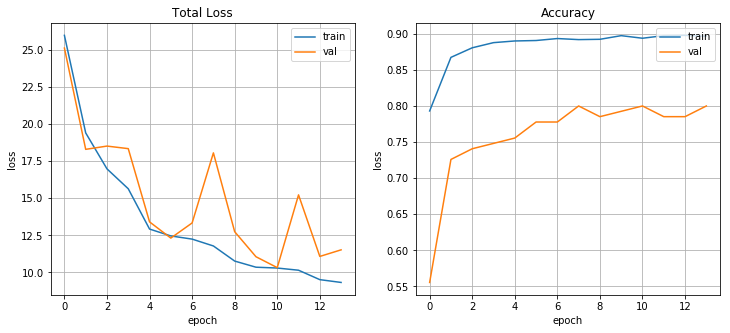

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_list_train, label='train')
plt.plot(loss_list_val, label='val')
plt.legend(loc='upper right')
plt.title('Total Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(acc_list_train, label='train')
plt.plot(acc_list_val, label='val')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

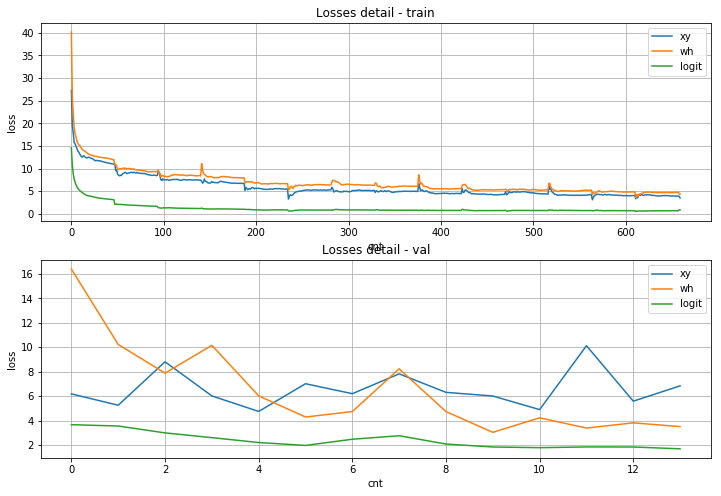

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(loss_xy_list['train'], label='xy')
plt.plot(loss_wh_list['train'], label='wh')
plt.plot(loss_logit_list['train'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - train')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_xy_list['val'], label='xy')
plt.plot(loss_wh_list['val'], label='wh')
plt.plot(loss_logit_list['val'], label='logit')
plt.legend(loc='upper right')
plt.title('Losses detail - val')
plt.xlabel('cnt')
plt.ylabel('loss')
plt.grid()
plt.show()

In [26]:
model.eval()
torch.save(model.state_dict(), 'torch_models/heatmap-edge2.pth')

---
# Test

In [27]:
import matplotlib.patches as patches

my_loader_test = torch.utils.data.DataLoader(my_dataset_val, batch_size=1, #collate_fn=myCollate,
                                          shuffle=True, num_workers=0)

loader = iter(my_loader_test)
model.eval()

def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

[80 59 44 91]
True [Pred]: 1 [GT]: 1


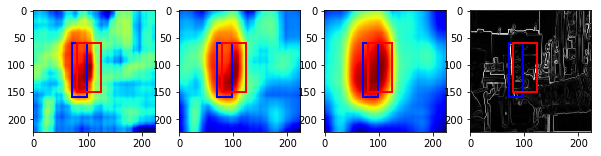

In [58]:
heatmap, box, target = loader.next()
box = box.cpu().numpy() 
box = cvt_yolobox(box, heatmap.shape[-2:])
x1,y1,w1,h1 = box[0]
logit, box_adj = model(heatmap.to(model.device))
_, pred = torch.max(logit, 1)
__, label = torch.max(target, 1)
box_adj = cvt_yolobox(box_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])
x2,y2,w2,h2 = box_adj[0]
print(box_adj[0])
print(pred.item()==label.item(), '[Pred]:', pred.item(), '[GT]:', label.item())

# Create figure and axes
fig = plt.figure(figsize=(10,10))

# Display the image
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    if(i==3): imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='gray')
    else: 
        imgplot = ax.imshow(heatmap[0][pred.item()][i].cpu(), cmap='jet')
    #     imgplot.set_clim(0,1)

    # Create a Rectangle patch
    rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
    rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect_pred)

plt.show()